In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

import sqlutilpy
import pandas as pd
import seaborn as sns

from wsdb import HOST, USER, PASSWORD
from src.classPatchMWSatellite import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('ori-dwarfs/ori-dwarfs.csv').drop(columns=['Unnamed: 0'])
df.sample(3)

,GalaxyName,RA_deg,Dec_deg,Distance_pc,rh(arcmins),rh_deg,rh_pc
38,PiscesII,344.629167,5.952500,181970.085861,1.1,0.018333,58.226248
30,LeoII,168.370000,22.151667,233345.806228,2.6,0.043333,176.481613
21,GrusII,331.020000,-46.440000,52966.344389,6.0,0.100000,92.443710


In [3]:
target = df.loc[df['GalaxyName'] == 'Fornax']
print(target)
print(' ')
print('rh of ' + target.iloc[0]['GalaxyName'] + ' is %0.2f pc' % target.iloc[0]['rh_pc'])

   GalaxyName     RA_deg    Dec_deg    Distance_pc  rh(arcmins)    rh_deg  \
19     Fornax  39.997083 -34.449167  147231.250243         16.6  0.276667   

         rh_pc  
19  710.942055  
 
rh of Fornax is 710.94 pc


In [4]:
DATABASE = 'gaia_dr2.gaia_source'
CATALOG_STR = """ ra, dec, phot_g_mean_mag, astrometric_excess_noise, 
                  pmra, pmdec, pmra_error, pmdec_error, parallax, parallax_error """

In [5]:
Patch = PatchMWSatellite(target.iloc[0]['GalaxyName'], 
                         target.iloc[0]['RA_deg'], 
                         target.iloc[0]['Dec_deg'], 
                         target.iloc[0]['Distance_pc'], 
                         5. * target.iloc[0]['rh_deg'], 
                         DATABASE, 
                         CATALOG_STR)
Patch.__str__()

'This is a PatchMWSatellite object:\n    name = Fornax\n    ra = 39.99708333333333\n    dec = -34.44916666666666\n    map width = 1.3833333333333337 deg\n    database = gaia_dr2.gaia_source\n'

In [6]:
Patch.sql_get(HOST, USER, PASSWORD)

Querying data in the patch using sqlutilpy.get():
    52747 sources are queried 



In [7]:
print('phot_g_mean_mag')
print(Patch.datas['phot_g_mean_mag'])
print(' ')
print('astrometric_excess_noise')
print(Patch.datas['astrometric_excess_noise'])

phot_g_mean_mag
[20.0732 13.2286 16.601  ... 19.0726 20.6708 21.2454]
 
astrometric_excess_noise
[0.         0.         0.16474578 ... 0.83691422 1.37262318 6.90056299]


In [8]:
Patch.mask_cut('phot_g_mean_mag', 17, 21)
Patch.mask_g_mag_astro_noise_cut()

Applying a cut: 17 < phot_g_mean_mag < 21:
    30154 sources left 

Applying astrometric_excess_noise and phot_g_mean_mag cut.
    29736 sources left 



In [9]:
Patch.mask_cut('parallax', 0, 15)

Applying a cut: 0 < parallax < 15:
    14222 sources left 



/home/kwhuang/Github/MilkyWaySatellites/src/classPatchMWSatellite.py:73: RuntimeWarning: invalid value encountered in greater
  maskleft = min_val < self.datas[catalog]
/home/kwhuang/Github/MilkyWaySatellites/src/classPatchMWSatellite.py:74: RuntimeWarning: invalid value encountered in less
  maskright = self.datas[catalog] < max_val


In [10]:
distance = 1. / Patch.datas['parallax']

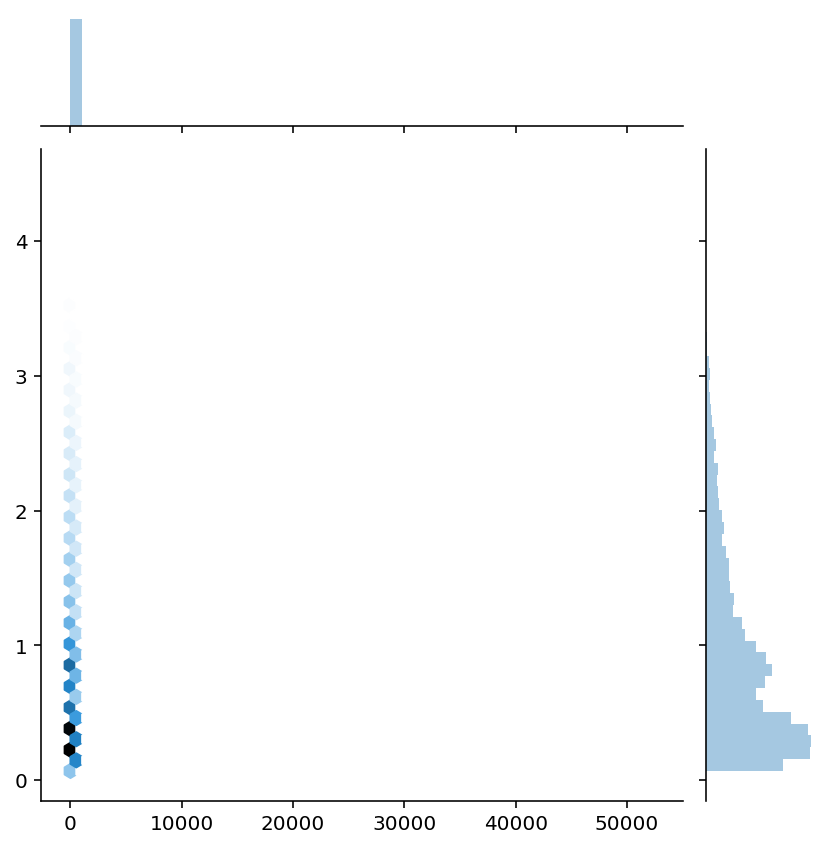

In [11]:
sns.jointplot(x=distance, y=Patch.datas['pmra_error'], kind='hex')

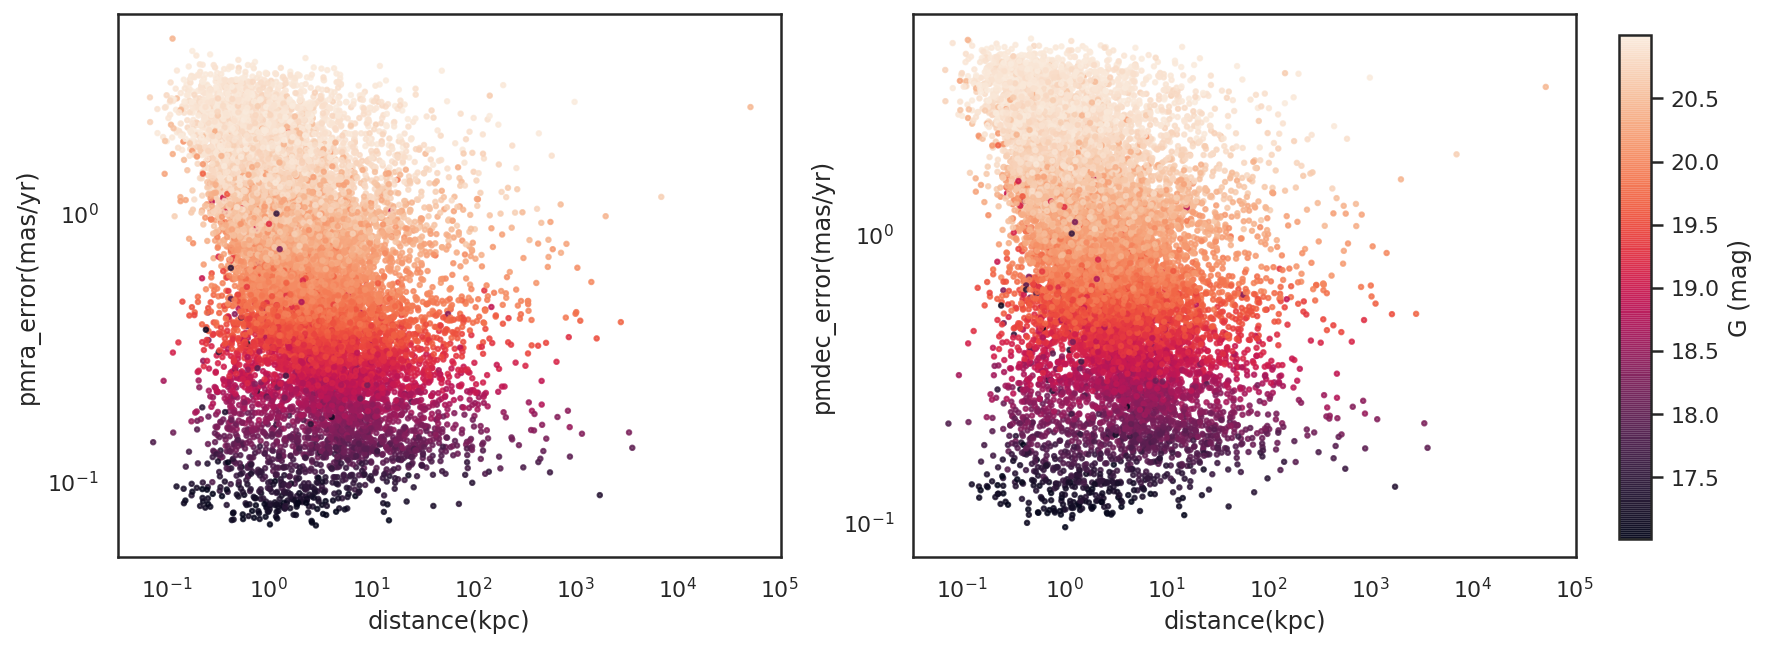

In [12]:
sns.set(style="white", color_codes=True, font_scale=1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

a = 0.8
s = 5

im = ax[0].scatter(distance, Patch.datas['pmra_error'],
                   c=Patch.datas['phot_g_mean_mag'],
                   alpha=a, s=s)

ax[1].scatter(distance, Patch.datas['pmdec_error'],
              c=Patch.datas['phot_g_mean_mag'],
              alpha=a, s=s)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label='G (mag)')

for i in range(2):
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].set_xlabel('distance(kpc)')
    
ax[0].set_ylabel('pmra_error(mas/yr)')
ax[1].set_ylabel('pmdec_error(mas/yr)')

# plt.savefig('pmerror_dist_gmag.png', bbox_inches='tight', dpi=300)